## Ejercicio

Tomar un ejemplo de los bots utilizados y onstruir el propio.

In [1]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
#!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

     |████████████████████████████████| 342 kB 4.2 MB/s 


In [2]:
import stanza
import spacy_stanza

In [24]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy

stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2022-08-10 08:06:39 INFO: Downloading default packages for language: es (Spanish)...


2022-08-10 08:08:34 INFO: Finished downloading models and saved to /root/stanza_resources.
2022-08-10 08:08:34 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2022-08-10 08:08:34 INFO: Use device: cpu
2022-08-10 08:08:34 INFO: Loading: tokenize
2022-08-10 08:08:34 INFO: Loading: mwt
2022-08-10 08:08:34 INFO: Loading: pos
2022-08-10 08:08:34 INFO: Loading: lemma
2022-08-10 08:08:34 INFO: Loading: depparse
2022-08-10 08:08:35 INFO: Loading: ner
2022-08-10 08:08:37 INFO: Done loading processors!


In [6]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])

    
    return text


In [8]:
text = "personas Ideas! a estás cosas y los peces y los murcielagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
print(preprocess_clean_text(text.lower()))

personas ideas a estas cosas y los peces y los murcielagos


### Diccionario de entrada

In [9]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola! Bienvenido a Movistar", "Hola, ¿Cómo estás? escribe tu consulta"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?"],
              "responses": ["Mi nombre es Movistar", "Yo soy Movistar"]
             },
             {"tag": "averias",
              "patterns": ["no tengo internet", "tengo problemas de conexion", "mi linea esta sin funcionar"],
              "responses": ["Contactaremos a un personal de servicio tecnico", "Puede seguir las siguientes opciones:", "¿Quieres contactar con servicio tecnico?"]
             },
            {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp"],
              "responses": ["Podes contactarnos al siguiente <numero>", "Contactos al whatsapp <numero>"]
             },
            {"tag": "envios",
              "patterns": ["¿Realizan envios?", "¿Cómo me llega el paquete?"],
              "responses": ["Tenemos diferentes formas de envios según la zona, te recomiendo entrar a este http://movistar.com/envios"]
             },
            {"tag": "planes",
              "patterns": ["Que planes postpago tiene?", "que planes hay", "plan de datos", "mis planes"],
              "responses": ["Tenemos planes de 4GB/6GB/10GB/20GB, mayor informacion visitanos al http://movistar.com/planes"]
             },
            {"tag": "saldo",
              "patterns": ["cuanto es mi saldo", "consulta de saldo"],
              "responses": ["Tu saldo actual es de $200"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }
]}

 ### Preprocesamiento y armado del dataset

In [10]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:
            #remove stop words
            lexeme = nlp.vocab[token.lemma_]
            if lexeme.is_stop == False:
              words.append(token.lemma_)
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [11]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['chau', 'conexion', 'consulta', 'contacto', 'dato', 'envio', 'funcionar', 'gracias', 'holar', 'internet', 'linea', 'llegar', 'nombre', 'numero', 'paquete', 'plan', 'postpago', 'problema', 'saldo', 'telefono', 'whatsapp']
classes: ['agradecimientos', 'averias', 'bienvenida', 'contacto', 'despedida', 'envios', 'nombre', 'planes', 'saldo']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Cúal es tu nombre?', '¿Quién sos?', 'no tengo internet', 'tengo problemas de conexion', 'mi linea esta sin funcionar', 'contacto', 'número de contacto', 'número de teléfono', 'número de whatsapp', 'whatsapp', '¿Realizan envios?', '¿Cómo me llega el paquete?', 'Que planes postpago tiene?', 'que planes hay', 'plan de datos', 'mis planes', 'cuanto es mi saldo', 'consulta de saldo', 'Muchas gracias', 'Gracias', 'Chau', 'Hasta luego!']
doc_y: ['bienvenida', 'bienvenida', 'bienvenida', 'nombre', 'nombre', 'averias', 'averias', 'averias', 'contacto', 'contacto', 'contacto', 'contacto', 'contacto', 'envios'

In [12]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 21


In [13]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 9


In [40]:
def get_processed_text(document):

    tokens = []
    for token in nlp(preprocess_clean_text(document.lower())):
      #remove stop words
      lexeme = nlp.vocab[token.lemma_]
      if lexeme.is_stop == False:
        tokens.append(token.lemma_)
    
    return tokens

In [43]:
word_vectorizer = TfidfVectorizer(tokenizer=get_processed_text)
all_word_vectors = word_vectorizer.fit_transform(doc_X)

In [67]:
word_vectorizer.transform(["Hola que tal"]).toarray().ravel()

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [45]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
      lexeme = nlp.vocab[token.lemma_]
      if lexeme.is_stop == False:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    # bow = []
    # for word in words:
    #     bow.append(1) if word in text else bow.append(0)

    bow = all_word_vectors.toarray()[idx]
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] y: [0, 0, 1, 0, 0, 0, 0, 0, 0]
X: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] y: [0, 0, 1, 0, 0, 0, 0, 0, 0]
X: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] y: [0, 0, 1, 0, 0, 0, 0, 0, 0]
X: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] y: [0, 0, 0, 0, 0, 0, 1, 0, 0]
X: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] y: [0, 0, 0, 0, 0, 0, 1, 0, 0]
X: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0.         0.70710678 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.70710678
 0.         0.         0.        ] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0.         0.         0.         0.         0.         0.
 0.70710678 0.         0.         0.         0.70710678 0.
 0.         0.         0.      

### Entrenamiento

In [46]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (21,) output: 9


In [47]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               2816      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 9)                 585       
                                                                 
Total params: 11,657
Trainable params: 11,657
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
train_X.shape

(25, 21)

In [48]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 537ms/step - loss: 2.2545 - accuracy: 0.0400
Epoch 2/200
1/1 [==============================] - 0s 14ms/step - loss: 2.2965 - accuracy: 0.1600
Epoch 3/200
1/1 [==============================] - 0s 13ms/step - loss: 2.2174 - accuracy: 0.0800
Epoch 4/200
1/1 [==============================] - 0s 11ms/step - loss: 2.2031 - accuracy: 0.1200
Epoch 5/200
1/1 [==============================] - 0s 10ms/step - loss: 2.2295 - accuracy: 0.0800
Epoch 6/200
1/1 [==============================] - 0s 21ms/step - loss: 2.2134 - accuracy: 0.0400
Epoch 7/200
1/1 [==============================] - 0s 14ms/step - loss: 2.2466 - accuracy: 0.0400
Epoch 8/200
1/1 [==============================] - 0s 11ms/step - loss: 2.1493 - accuracy: 0.1200
Epoch 9/200
1/1 [==============================] - 0s 9ms/step - loss: 2.1576 - accuracy: 0.1600
Epoch 10/200
1/1 [==============================] - 0s 9ms/step - loss: 2.2016 - accuracy: 0.0400
Epoch 11/200
1/1 [==

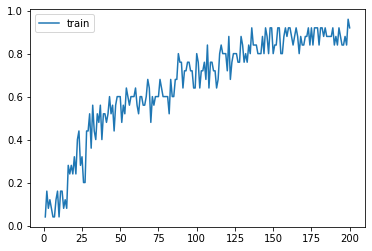

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [50]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

 ### Testing y validación

In [79]:
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
      lexeme = nlp.vocab[token.lemma_]
      if lexeme.is_stop == False:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab): #tf-idf
    return word_vectorizer.transform([text]).toarray().ravel()
    
    # tokens = text_to_tokens(text)
    # bow = [0] * len(vocab)
    # for w in tokens: 
    #     for idx, word in enumerate(vocab):
    #         if word == w: 
    #             bow[idx] = 1
    # #print(bow)
    # return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [80]:
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Perdón, no comprendo la pregunta.")
    

Hola
BOT: Hola! Bienvenido a Movistar
plan
BOT: Tenemos planes de 4GB/6GB/10GB/20GB, mayor informacion visitanos al http://movistar.com/planes
que plan tenes
BOT: Tenemos planes de 4GB/6GB/10GB/20GB, mayor informacion visitanos al http://movistar.com/planes
mi internet esta fallando
BOT: Puede seguir las siguientes opciones:
no tengo internet 
BOT: Puede seguir las siguientes opciones:
mi internet no funciona
BOT: Contactaremos a un personal de servicio ternico
cual es mi saldo
BOT: Tu saldo actual es de $200
saldo
BOT: Tu saldo actual es de $200


KeyboardInterrupt: ignored

### Conclusiones

*   Se uso eliminacion de stop words y TF-IDF
*   Se obtuvieron similares resultados que usando lo visto en clase.

